In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np
import pandas as pd

In [2]:
mnist = fetch_openml('mnist_784',version= 1, as_frame=False)

In [ ]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

## Tập dữ liệu `Minist` chứa 70000 ảnh và 28 * 28 đặc trưng (vì có 28*28 điểm ảnh)

In [ ]:
X, Y = mnist['data'],mnist['target']
X.shape,Y.shape

((70000, 784), (70000,))

## Mỗi đặc trưng đại diện cho cường độ của một điểm ảnh với giá trị trong khoảng 0 (trắng) đến 255 (Đen)

## Ta thấy nhãn và mẫu đều bằng 5

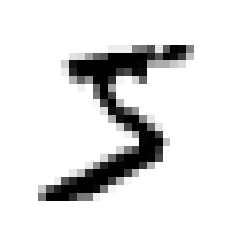

In [ ]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap = 'binary')
plt.axis("off")
plt.show()

In [ ]:
Y = Y.astype(np.uint8)

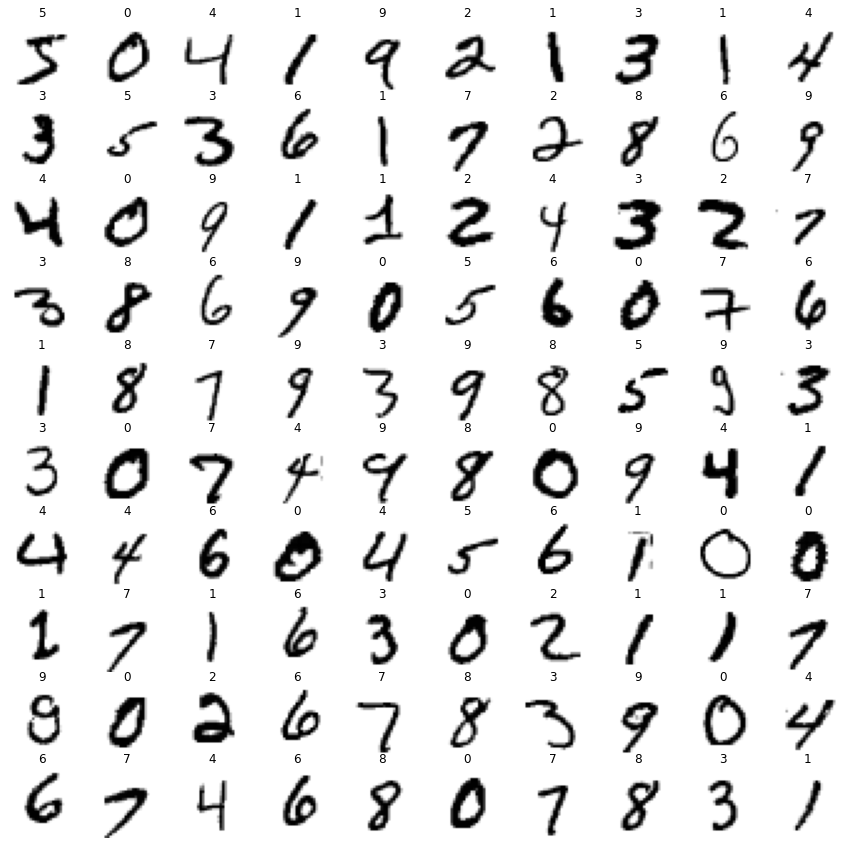

In [ ]:
some_digits = X[:100]
some_digit_images = [i.reshape(28,28) for i in some_digits]
row = 10
col = 10
plt.figure(figsize= (15,15))
for index in range(1,101):
    a = plt.subplot(row,col,index)
    a.imshow(some_digit_images[index-1],cmap = 'binary')
    plt.axis("off")
    plt.title(Y[index-1])
    index += 1
plt.savefig("more_digit_plot")

## Tập dữ liệu `Minist` đã chia sẵn tập huấn luyện và tập kiểm tra
## Tập huấn luyện đã được xáo trộn để đảm bảo các fold trong kiểm định chéo sẽ tương tự nhau

In [ ]:
X_train,Y_train,X_test,Y_test = X[:60000],Y[:60000],X[60000:],Y[60000:]


In [ ]:
Y_train_5 = (Y_train == 5)
Y_test_5 = (Y_test == 5)

# Bộ phân loại nhị phân

## Huấn luyện với bộ phân loại `Hạ Gradient ngẫu nhiên` ( Stochastic Gradient Descent - SGD)
* Ưu điểm : khả năng xử lí dữ liệu lớn hiệu quả, một phần vì xử lí từng mẫu dữ liệu một cách độc lập

In [ ]:
from sklearn.linear_model import SGDClassifier
sgdc_clf = SGDClassifier(max_iter=1000,tol = 1e-3,random_state= 42)
sgdc_clf.fit(X_train,Y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgdc_clf.predict([some_digit])

array([ True])

# Phép đo chất lượng

## Đánh giá độ chính xác bằng kiểm định chéo (KFold)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits =3,random_state = 42,shuffle= True)

for train_index,test_index in skfolds.split(X_train,Y_train_5):
    sgdc_clf_clone = clone(sgdc_clf)
    X_train_folds = X_train[train_index]
    Y_train_folds = Y_train_5[train_index]
    X_test_folds = X_train[test_index]
    Y_test_folds = Y_train_5[test_index]
    sgdc_clf_clone.fit(X_train_folds,Y_train_folds)
    y_predict = sgdc_clf_clone.predict(X_test_folds)
    n_correct = sum(y_predict == Y_test_folds)
    print(n_correct / len(y_predict))

0.9669
0.91625
0.96785


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgdc_clf,X_train,Y_train_5,scoring= 'accuracy',cv = 3)

array([0.95035, 0.96035, 0.9604 ])

### Xem thử độ chính xác của nhãn `Không phải 5`

In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifer(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype= bool) # các giá trị = False hết
never_5_clf = Never5Classifer()
cross_val_score(never_5_clf,X_train,Y_train_5,cv = 3,scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

=> độ chính xác trên 90% là do chỉ có khoảng 10% ảnh có nhãn là 5 

### `=> Điều này minh họa lí do vì sao độ chính xác nhìn chung không phải phép đo chất lượng được ưa dùng cho các bộ phân loại, đặc biệt khi ta đang làm việc với tập dữ liệu lệch (skwed dataset), tức là khi một vài lớp có nhiều dữ liệu hơn các lớp khác`

## Ma trận nhầm lẫn (Confusion Matrix)
* Ý tưởng chính là tính số lần một mẫu của lớp A bị phân loại nhầm thành lớp B

In [ ]:
from sklearn.model_selection import cross_val_predict  
y_train_pred = cross_val_predict(sgdc_clf,X_train,Y_train_5,cv = 3)
y_train_pred

KeyboardInterrupt: 

### Confusion Matrix
 * Mỗi hàng biểu diễn lớp thật, mỗi cột biểu diễn lớp dự đoán
   * Dòng 1: Không phải 5(lớp âm) 
    * Dòng 2: lớp 5(lớp dương)
  
    | True Negative  |  False Positive |  
    |      ---       |         ---     |
    | False Negative |  True Positive  |

![CF](Confusion_Matrix.png)


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train_5,y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### Một bộ phân loại hoàn hảo chỉ có `True Negative` và `True Positive`, tức là nằm trên đường chéo chính

In [ ]:
y_train_perfect_pred = Y_train_5 # Giả sử
confusion_matrix(Y_train_5,y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Phép đo độ chính xác cho lớp dương
$$precision = \frac{TP} {TP+FP}$$
* TP: số mẫu dương tính thật(True Positive)
* FP: số mẫu dương tính giả (False Positive)

In [ ]:
from sklearn.metrics import precision_score
precision_score(Y_train_5,y_train_pred)

0.8370879772350012

In [ ]:
cm[1,1]/(cm[1,1]+cm[0,1])

0.8370879772350012

### Phép đo Recall, còn được gọi là độ nhạy(sensitive) hoặc `True Positive Rate`: tỉ lệ mẫu dương được phát hiện bởi bộ phân loại
$$ recall = \frac {TP} {TP+FN}$$

In [ ]:
from sklearn.metrics import recall_score
recall_score(Y_train_5,y_train_pred)

0.6511713705958311

In [ ]:
cm[1,1] / (cm[1,1] + cm[1,0])

0.6511713705958311

#### => Trong tổng số lần bộ phân loại gán nhãn là 5, nó chỉ đúng 83.7%
#### =>  Trong tổng số ảnh 5, nó chỉ đúng 65,11%


### Trung bình điều hòa F1 của Precision và Recall
* Với các trung bình thông thường thì các giá trị được coi là như nhau còn trung bình điều hòa đánh trọng số lớn hơn cho các giá trị nhỏ
* Do đó một bộ phân loại chỉ có thể đạt chỉ số F1 cao nếu Precision và Recall đều cao
$$F_1 = \frac {2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision * recall}{precision+recall} = \frac{TP}{TP+ \frac{FN+TP}{2}} $$

In [ ]:
from sklearn.metrics import f1_score
f1_score(Y_train_5,y_train_pred)

0.7325171197343846

### Đánh đổi Precision và Recall


#### Sklearn không cho phép ta đặt mức ngưỡng một cách trực tiếp nhưng cho phép ta lấy điểm số mà mô hình dùng để đưa ra dự đoán.

In [ ]:
y_scores = sgdc_clf.decision_function([some_digit])
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

=> Xác nhận tăng mức ngưỡng là giảm Recall

#### Xác định ngưỡng thích hợp

In [ ]:
y_scores = cross_val_predict(sgdc_clf,X_train,Y_train_5,cv = 3,method = 'decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [ ]:
from sklearn.metrics import precision_recall_curve
precision,recall,threshold = precision_recall_curve(Y_train_5,y_scores)

Text(0.5, 0, 'Threshold')

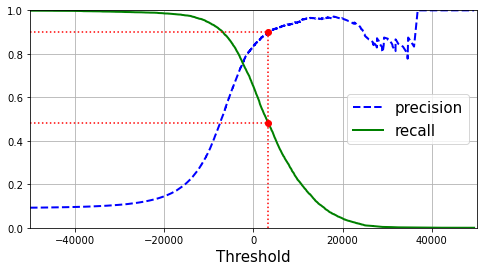

In [ ]:
def plot_precision_recall_threshold(precision,recall,threshold):
    plt.plot(threshold,precision[:-1],'b--',label = "precision",linewidth = 2)
    plt.plot(threshold,recall[:-1],'g-',label = "recall",linewidth = 2,)
    plt.legend(loc = 'center right',fontsize = 15)
    plt.axis([-50000,50000,0,1])
    plt.grid(True)

plt.figure(figsize = (8,4))
#add threshold line
recall_90_precision = recall[np.argmax(precision >= 0.9)] #find index first of precision > 0.9 (First True)
threshold_90_precision = threshold[np.argmax(precision >= 0.9)]

plot_precision_recall_threshold(precision,recall,threshold)
plt.plot([threshold_90_precision,threshold_90_precision],[0,0.9],'r:')
plt.plot([-50000,threshold_90_precision],[recall_90_precision,recall_90_precision],'r:')
plt.plot([-50000,threshold_90_precision],[0.9,0.9],'r:')
plt.plot([threshold_90_precision],[recall_90_precision],'ro')
plt.plot(threshold_90_precision,0.9,'ro')

plt.xlabel("Threshold",fontsize = 15)

<Figure size 576x288 with 0 Axes>

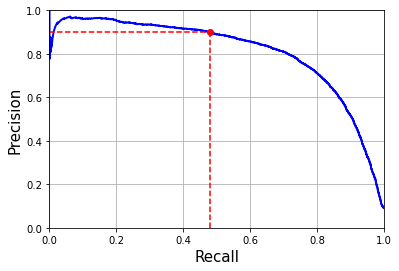

<Figure size 576x288 with 0 Axes>

In [ ]:
def plot_precision_and_recall(precision,recall):
    plt.plot(recall,precision,'b-',linewidth = 2)
    plt.xlabel("Recall",fontsize = 15)
    plt.ylabel("Precision",fontsize = 15)
    plt.grid(True)
    
plt.axis([0,1,0,1])

plot_precision_and_recall(precision,recall)

plt.plot([recall_90_precision,recall_90_precision],[0,0.9],'r--')
plt.plot([0,recall_90_precision],[0.9,0.9],'r--')
plt.plot(recall_90_precision,0.9,'ro')

plt.figure(figsize=(8,4))

#### => Ta thấy Precision giảm nhanh ở recall 80%

#### Tìm mức ngưỡng nhỏ nhất đem lại precision >= 0.9 (First True)

In [ ]:
threshold_90_precision = threshold[np.argmax(precision >= 0.9)]
threshold_90_precision

3370.0194991439557

In [ ]:
y_train_pred_90 = y_scores >= threshold_90_precision
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [ ]:
precision_score(Y_train_5,y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(Y_train_5,y_train_pred_90)

0.4799852425751706

### Đường cong ROC
* Vẽ tỉ lệ `TPR`(tên gọi khác của recall) theo tỉ lệ `FPR`(tỉ lệ mẫu âm tính bị phân loại sai thành dương tính)
*   Với `FPR` = 1 - `TNR`( còn được gọi là `specificity`) 
#### => biểu đồ thể hiện sensitivity(recall) theo 1 - specificity


In [ ]:
from sklearn.metrics import roc_curve
fpr,tpr,threshold = roc_curve(Y_train_5,y_scores)

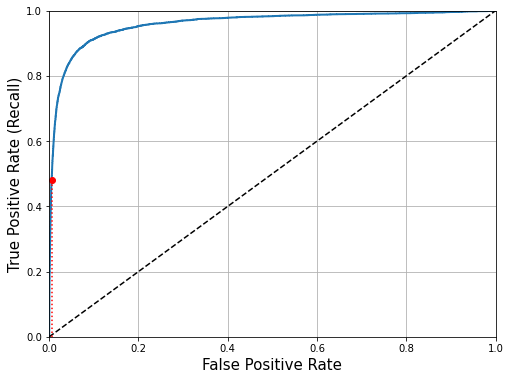

In [ ]:
def plot_roc_curve(fpr,tpr,label = None):
    plt.plot(fpr,tpr,linewidth = 2,label = label)
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate",fontsize = 15)
    plt.ylabel("True Positive Rate (Recall)",fontsize = 15)
    x = np.linspace(0,1,100)
    plt.plot(x,x,'k--')
    plt.grid(True)
plt.figure(figsize = (8,6))
plot_roc_curve(fpr,tpr)

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90,fpr_90],[0,recall_90_precision],'r:')
plt.plot([0,fpr_90],[recall_90_precision,recall_90_precision],'r:')
plt.plot([fpr_90],[recall_90_precision],'ro')


=> Recall càng cao, tỉ lệ FPR càng lớn

=> Một bộ phân loại tốt sẽ có đường cong ROC càng xa đường nét đứt càng tốt (về phía góc trên bên trái)

#### Một cách để so sánh các bộ phân loại là tính diện tích dưới đường cong (area under the curve - AUC)
* Một bộ phân loại hoàn hảo sẽ có ROC AUC = 1 trong khi bộ phân loại hoàn toàn ngẫu nhiên sẽ có ROC AUC = 0.5


![CF](ROC_PR.png)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_train_5,y_scores)

0.9604938554008616

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
# predict_proba : trả về số hàng là số mẫu, số cột là số lớp (ko phải 5,là 5)
y_proba_pred = cross_val_predict(forest_clf,X_train,Y_train_5,cv = 3,method = "predict_proba")

In [ ]:
y_proba_pred

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [ ]:
y_score_forest = y_proba_pred[:,1]
fpr_forest,tpr_forest,threshold_forest = roc_curve(Y_train_5,y_score_forest)

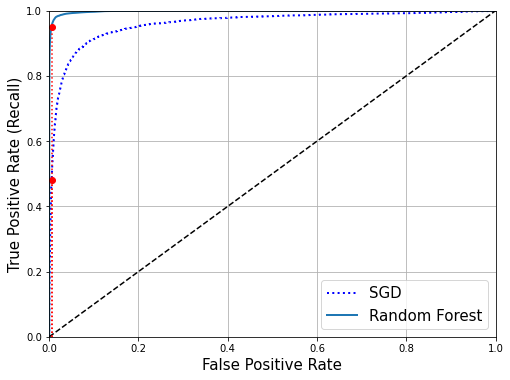

In [ ]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]
plt.figure(figsize = (8,6))

plt.plot(fpr,tpr,'b:',label = 'SGD',linewidth = 2)
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")

plt.plot(fpr_90,recall_90_precision,'ro')
plt.plot([fpr_90,fpr_90],[0,recall_90_precision],'r:')
plt.plot([0,fpr_90],[recall_90_precision,recall_90_precision],'r:')

plt.plot(fpr_90,recall_for_forest,'ro')
plt.plot([fpr_90,fpr_90],[0,recall_for_forest],'r:')
plt.plot([0,fpr_90],[recall_90_precision,recall_90_precision],'r:')

plt.legend(loc= 'lower right',fontsize = 15)

In [ ]:
roc_auc_score(Y_train_5,y_score_forest)

0.9983436731328145

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf,X_train,Y_train_5,cv = 3)


In [ ]:
precision_score(Y_train_5,y_train_pred_forest),recall_score(Y_train_5,y_train_pred_forest)

(0.9905083315756169, 0.8662608374838591)

# Phân loại đa lớp


## Phân loại bằng Support Vector Classification : SVC

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42,gamma = 'auto')
svm_clf.fit(X_train[:1000],Y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score #Score class

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [ ]:
np.argmax(some_digit_score) #Index of max score

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[np.argmax(some_digit_score)]

5

## OneVsOne: 
* Huấn luyện bộ phân loại nhị phân cho mỗi cặp số
* Chọn lớp có thắng nhiều nhất
* `Ưu điểm: mỗi bộ phân loại chỉ cần được huấn luyện trên một phần nhỏ của tập huấn luyện chứa 2 lớp cần phân biệt`

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SVC())
ovo_clf.fit(X_train[:1000],Y_train[:1000])

OneVsOneClassifier(estimator=SVC())

In [ ]:
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovo_clf.estimators_) 

45

### `=> Ta thấy OVS đc chia thành 45 lớp`

## OneVsRest: 
* Huấn luyện n bộ phân loại nhị phân, một bộ cho mỗi chữ số
* tính điểm của mỗi bộ phân loại và chọn lớp có điểm cao nhất

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr = OneVsRestClassifier(SVC())
ovr.fit(X_train[:1000],Y_train[:1000])

OneVsRestClassifier(estimator=SVC())

In [ ]:
ovr.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
ovr.decision_function([some_digit])

array([[-1.34386   , -1.51948026, -1.22096067, -0.92938037, -2.00572727,
         0.6077433 , -1.62258907, -0.99975597, -1.2763794 , -1.70311184]])

In [ ]:
len(ovr.estimators_)

10

### `=> Ta thấy OVR đc chia thành 10 lớp`

## SGD

In [ ]:
sgdc_clf.fit(X_train,Y_train)
sgdc_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgdc_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgdc_clf,X_train,Y_train,cv=3,scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train_scale = std_scaler.fit_transform(X_train)
cross_val_score(sgdc_clf,X_train_scale,Y_train,cv = 3,scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

# Phân tích lỗi


In [ ]:
y_train_pred = cross_val_predict(sgdc_clf,X_train_scale,Y_train,cv = 3)

In [ ]:
conf_matrix = confusion_matrix(Y_train,y_train_pred)

In [ ]:
conf_matrix # row: real,col: predict

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

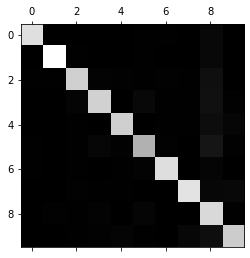

In [ ]:
plt.matshow(conf_matrix,cmap = plt.cm.gray)

In [ ]:
row_sums = conf_matrix.sum(axis = 1,keepdims=True)
norm_conf_mx = conf_matrix/row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx,0)

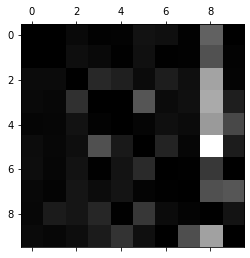

In [ ]:
plt.matshow(norm_conf_mx,cmap = plt.cm.gray)

In [ ]:
X_33 = X_train[(Y_train == 3) & (y_train_pred == 3)]
X_35 = X_train[(Y_train == 3) & (y_train_pred == 5)]
X_53 = X_train[(Y_train == 5) & (y_train_pred == 3)]
X_55 = X_train[(Y_train == 5) & (y_train_pred == 5)]

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images = [i.reshape(size,size) for i in instances]
    images_per_row = min(len(instances),images_per_row)
    n_rows = ((len(instances)-1) // images_per_row) + 1
    n_image = []
    for row in range(n_rows):
        multi_image = images[row * images_per_row : (row+1) * images_per_row]
        n_image.append(np.concatenate(multi_image,axis = 1))
    image = np.concatenate(n_image,axis = 0)
    plt.imshow(image,cmap = plt.cm.binary)
    plt.axis("off")

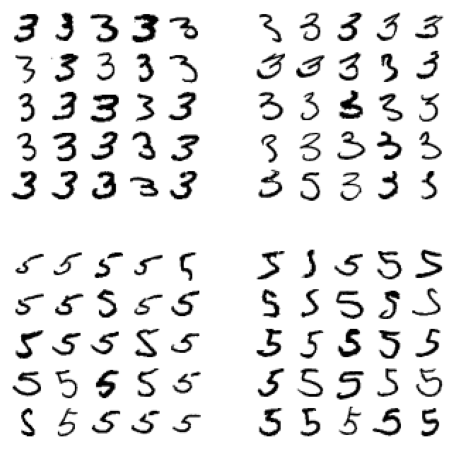

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(221)
plot_digits(X_33[:25],images_per_row= 5)
plt.subplot(222)
plot_digits(X_35[:25],images_per_row= 5)
plt.subplot(223)
plot_digits(X_55[:25],images_per_row= 5)
plt.subplot(224)
plot_digits(X_53[:25],images_per_row= 5)

# Phân loại đa nhãn
` Là hệ thống phân loại trả về >= 1 nhãn `

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = Y_train >= 7
y_train_odd = (Y_train % 2 !=0)
y_multi_label = np.c_[y_train_large,y_train_odd]

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multi_label)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit]) # so 5

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multi_label,cv = 3)
f1_score(y_multi_label,y_train_knn_pred,average = 'macro')

KeyboardInterrupt: 

# Phân loại đa đầu ra


In [ ]:
noise = np.random.randint(1,100,(len(X_train),784))
X_train_mod = X_train + noise 
noise = np.random.randint(1,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

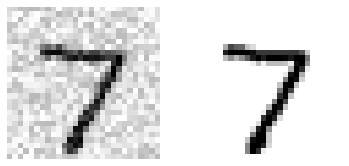

In [ ]:
plt.subplot(121)
plot_digits([X_test_mod[0]])
plt.subplot(122)
plot_digits([y_test_mod[0]])

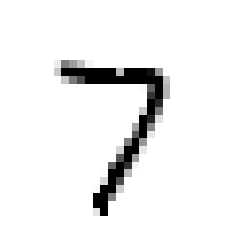

In [ ]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_predict = knn_clf.predict([X_test_mod[0]])
plot_digits([clean_predict])

# Bài tập 1:
* Xây dựng một bộ phân loại cho tập dữ liệu MNIST trên tập kiểm tra có độ chính xác trên 97%

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn_clf = KNeighborsClassifier()


In [ ]:
from sklearn.model_selection import GridSearchCV
knn_param_grid = [
    {'weights': ['uniform','distance']},
    {'n_neighbors': [i for i in range(6)]}
]
grid_knn = GridSearchCV(knn_clf,knn_param_grid,cv = 3,verbose = 3)
grid_knn.fit(X_train,Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END ...................weights=uniform;, score=0.968 total time=  22.6s
[CV 2/3] END ...................weights=uniform;, score=0.967 total time=  22.4s


KeyboardInterrupt: 

# Bài tập 2

In [ ]:
from scipy.ndimage.interpolation import shift
def shift_image(image,dx,dy):
    image = image.reshape((28,28))
    shift_image = shift(image,[dy,dx],cval=0,mode = 'constant')
    return shift_image.reshape([-1])


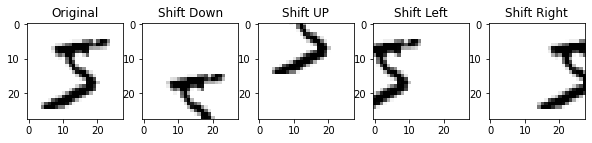

In [ ]:
image = X_train[0]
shift_image_down = shift_image(image,0,10)
shift_image_up = shift_image(image,0,-10)
shift_image_left = shift_image(image,-10,0)
shift_image_right = shift_image(image,10,0)
plt.figure(figsize = (10,8))

plt.subplot(151)
plt.title("Original")
plt.imshow(image.reshape(28,28),cmap = 'binary')

plt.subplot(152)
plt.title("Shift Down")
plt.imshow(shift_image_down.reshape(28,28),cmap = 'binary')
plt.subplot(153)
plt.title("Shift UP")
plt.imshow(shift_image_up.reshape(28,28),cmap = 'binary')
plt.subplot(154)
plt.title("Shift Left")
plt.imshow(shift_image_left.reshape(28,28),cmap = 'binary')
plt.subplot(155)
plt.title("Shift Right")
plt.imshow(shift_image_right.reshape(28,28),cmap = 'binary')

In [ ]:
X_train_augmentation = [image for image in X_train]
Y_train_augmentation = [label for label in Y_train]
position = [(-3,0),(3,0),(0,3),(0,-3)]
for dx,dy in position:
    for image,label in zip(X_train,Y_train):
        X_train_augmentation.append(shift_image(image,dx,dy))
        Y_train_augmentation.append(label)

In [ ]:
X_train_augmentation = np.array(X_train_augmentation)
Y_train_augmentation = np.array(Y_train_augmentation)

In [ ]:
shuffle = np.random.permutation(len(X_train_augmentation))
X_train_augmentation = X_train_augmentation[shuffle]
Y_train_augmentation = Y_train_augmentation[shuffle]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_augmentation,Y_train_augmentation)

KNeighborsClassifier()

In [ ]:
y_pred = knn_clf.predict(X_test)

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,y_pred)

0.9810633333333333